# Kütüphanelerin Import Edilmesi

In [2]:
import warnings # Uygulamanın çalışmasında sıkıntı çıkarmayacak uyarıları filtrelemek için.
warnings.filterwarnings("ignore") # <==

import numpy as np # Matris ve Lineer Cebir İşlemleri
import pandas as pd # Veri İşleme

# Görselleştirme
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")
import seaborn as sns

from collections import Counter # Dizilerdeki eleman sayılarını Sözlük biçiminde veriyor.


# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score


# Veriyi İçeri Aktar ve Kontrol Et

In [3]:
train_df = pd.read_csv("Titanic-Dataset.csv")

In [4]:
# Değişkenlere göz atalım
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [5]:
# İlk 5 değere bakalım
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
# Verinin temel özelliklerine göre bir özet çıkaralım.
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
# Değişken isimlerine Türkçe isim vermek
train_df.columns = ["id", "hayatta_kalma", "sinif", "isim", "cinsiyet", "yas", "kardes_es", "ebeveyn_cocuk", "bilet", "ucret", "kabin", "liman"]

In [9]:
train_df.head(2)

,id,hayatta_kalma,sinif,isim,cinsiyet,yas,kardes_es,ebeveyn_cocuk,bilet,ucret,kabin,liman
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


# Tek Değişken Analizi
- **Kategorik Değişken**: *hayatta_kalma*, *cinsiyet*, *sinif*, *liman*, *kabin*, *isim*, *bilet*, *kardes_es*, *ebeveyn_cocuk*
- **Sayısal Değişken**: *ucret*, *yas*, *id*

In [10]:
cat_cols = [col for col in train_df.columns if train_df[col].dtype=="object"]
cat_cols += [col for col in train_df.columns if train_df[col].dtype in (int, float) and train_df[col].nunique()<15]
cat_cols

['isim',
 'cinsiyet',
 'bilet',
 'kabin',
 'liman',
 'hayatta_kalma',
 'sinif',
 'kardes_es',
 'ebeveyn_cocuk']

In [11]:
num_cols = [col for col in train_df.columns if train_df[col].dtype in (int, float) and train_df[col].nunique()>15]
num_cols

['id', 'yas', 'ucret']

#### Kategorik Değişken

In [12]:
# Çubuk Grafiği ile kategorik değişkenlerimizi görselleştiren bir fonksiyon yazıyoruz.
def barPlot(degisken):
    """

        Girdi: Kategorik bir değişken. -> Cinsiyet, İsim vb.
        Çıktı: Değişkene İlişkin bir Çubuk Grafiği
    """

    # DataFrame içinden değişkenimizi alalım.
    ozellik = train_df[degisken]

    # Kategorik Değişken Sayısını Hesaplayalım.
    ozellik_degeri = ozellik.value_counts()

    # Görselleştirme
    plt.figure(figsize= (9,4)) # Büyüklük Ayarı
    plt.bar(ozellik_degeri.index, ozellik_degeri)
    plt.xticks(ozellik_degeri.index, ozellik_degeri.index.values)
    plt.ylabel("Frekans")
    plt.title(degisken)
    plt.show()

    print(f"{degisken}: \n {ozellik_degeri}")



cinsiyet
---------------


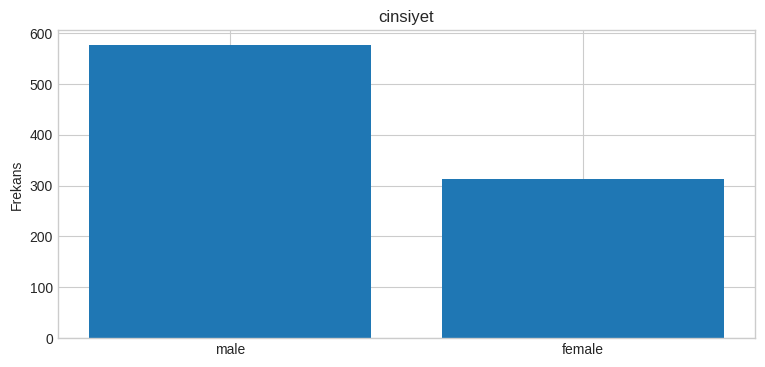

cinsiyet: 
 cinsiyet
male      577
female    314
Name: count, dtype: int64
---------------
---------------


liman
---------------


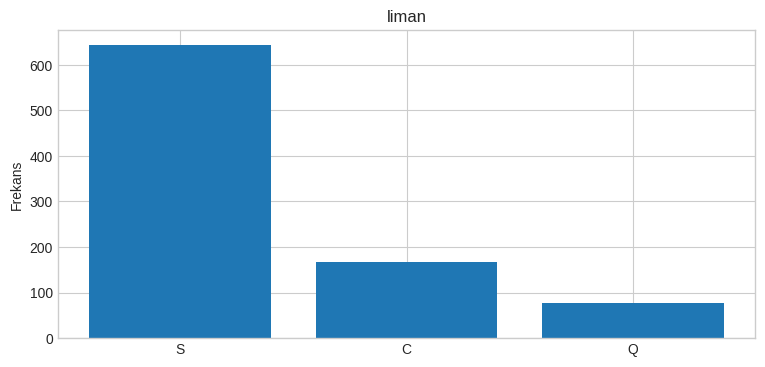

liman: 
 liman
S    644
C    168
Q     77
Name: count, dtype: int64
---------------
---------------


hayatta_kalma
---------------


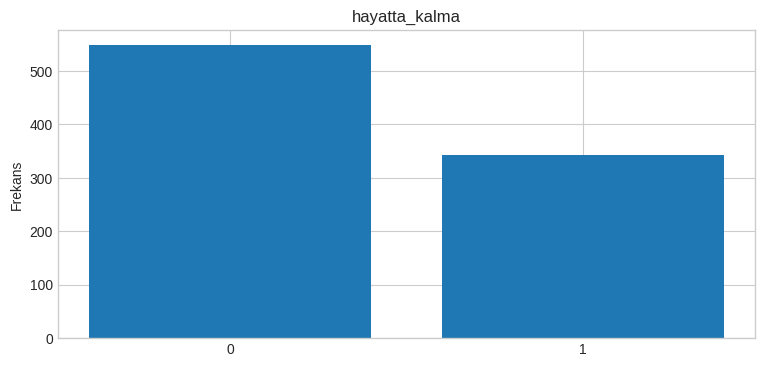

hayatta_kalma: 
 hayatta_kalma
0    549
1    342
Name: count, dtype: int64
---------------
---------------


sinif
---------------


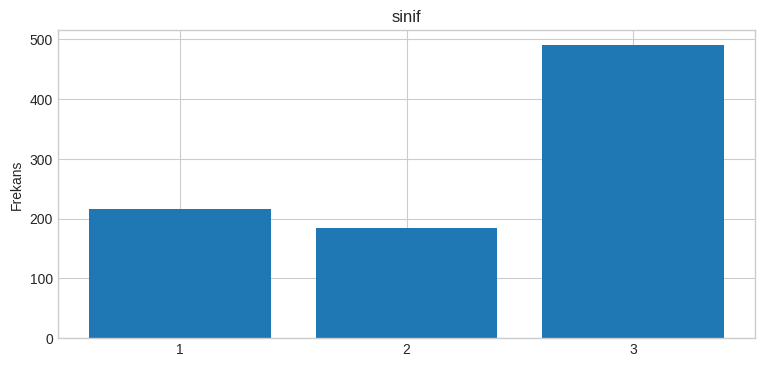

sinif: 
 sinif
3    491
1    216
2    184
Name: count, dtype: int64
---------------
---------------


kardes_es
---------------


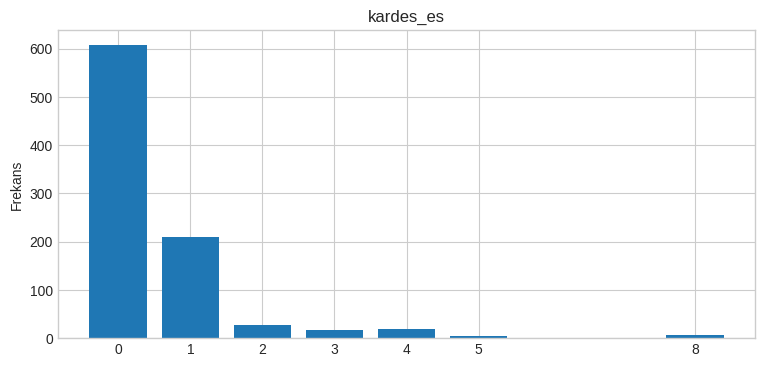

kardes_es: 
 kardes_es
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: count, dtype: int64
---------------
---------------


ebeveyn_cocuk
---------------


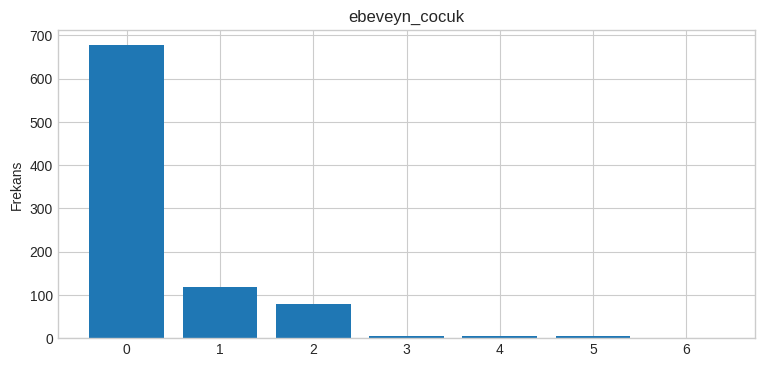

ebeveyn_cocuk: 
 ebeveyn_cocuk
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: count, dtype: int64
---------------
---------------




In [13]:
for col in [col for col in cat_cols if train_df[col].nunique()<15]:
    print(col)
    print("-"*15)
    # Grafik
    barPlot(col)
    print("-"*15)
    print("-"*15)
    print("\n")
    

#### Sayısal Değişken

In [14]:
# Sayısal değişkenlere ilişkin Histogram Grafiği çizdirme fonksiyonu
def histPlot(degisken):
    """
    
        Girdi: Herhangi bir sayısal değişken
        Çıktı: Verilen Değişken özelinde histogram grafiği
    """
    plt.figure(figsize=(9,4))
    plt.hist(train_df[degisken], bins=50)
    plt.xlabel(degisken)
    plt.ylabel("Frekans")
    plt.title(f"{degisken} Histogramı")
    plt.show()

---------------
id


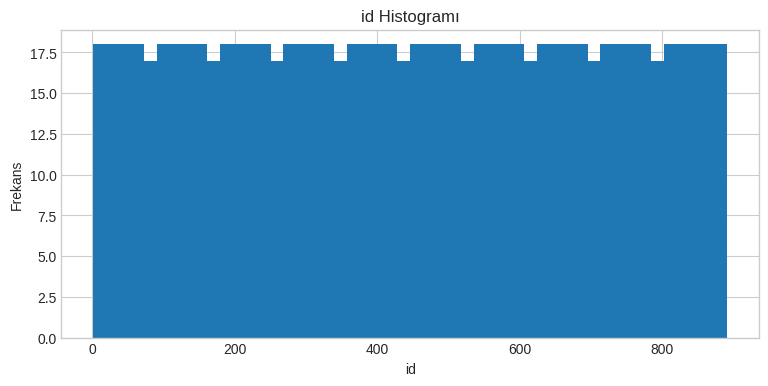

id
count    891.000000
mean     446.000000
std      257.353842
min        1.000000
25%      223.500000
50%      446.000000
75%      668.500000
max      891.000000
Name: id, dtype: float64
0        1
1        2
2        3
3        4
4        5
      ... 
886    887
887    888
888    889
889    890
890    891
Name: id, Length: 891, dtype: int64
---------------
---------------
yas


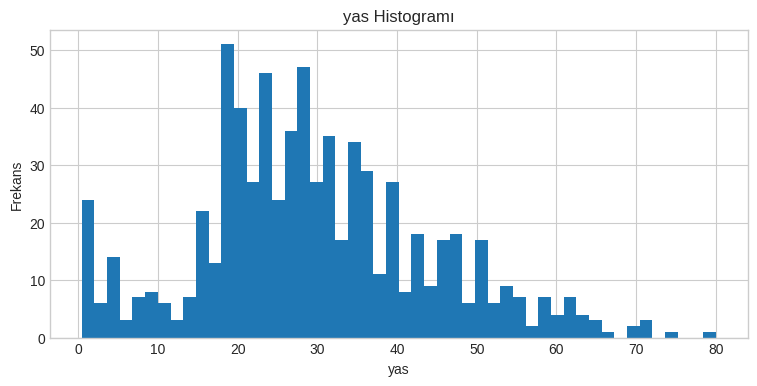

yas
count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: yas, dtype: float64
0    24.0
Name: yas, dtype: float64
---------------
---------------
ucret


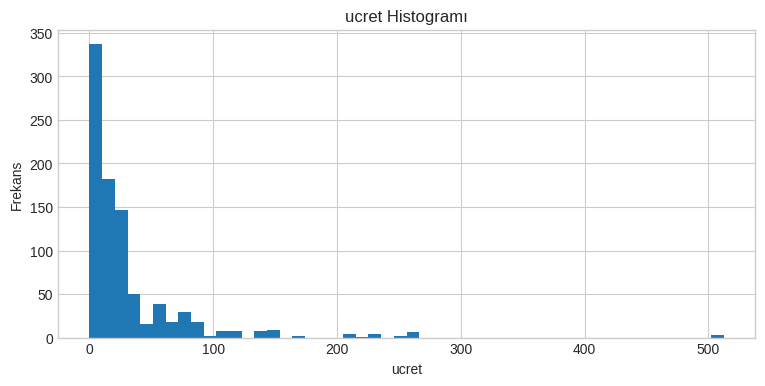

ucret
count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: ucret, dtype: float64
0    8.05
Name: ucret, dtype: float64
---------------


In [21]:
for col in num_cols:
    print("-"*15)
    print(col)
    histPlot(col)
    print(col)
    print(train_df[col].describe().T)
    print(train_df[col].mode())
    print("-"*15)
    

### Temel Veri Analizi

Bu bölümde farklı değişkenler ile hayatta kalma durumunu inceleyeceğiz.
- _sinif - hayatta\_kalma_
- _cinsiyet - hayatta\_kalma_
- _kardes_es - hayatta\_kalma_
- _ebeveyn_cocuk - hayatta\_kalma_


##### sinif - hayatta_kalma

In [50]:
train_df.groupby("sinif", as_index=False)["hayatta_kalma"].mean().sort_values(by="hayatta_kalma", ascending=False)
# Sınıf düştükçe hayatta kalma oranı da düşüyor maalesef :(
# sinif hayatta kalma - kalmama sınıflandırmasında etkili bir değişken.

,sinif,hayatta_kalma
0,1,0.629630
1,2,0.472826
2,3,0.242363


#### cinsiyet - hayatta_kalma

In [51]:
train_df.groupby("cinsiyet", as_index=False)["hayatta_kalma"].mean().sort_values(by="hayatta_kalma", ascending=False)
# Tam olarak düşündüğümüz gibi önce kadınlar ve çocuklar :)
# cinsiyet hayatta kalma - kalmama sınıflandırmasında etkili bir değişken.

,cinsiyet,hayatta_kalma
0,female,0.742038
1,male,0.188908


#### kardes_es - hayatta_kalma

In [52]:
train_df.groupby("kardes_es", as_index=False)["hayatta_kalma"].mean().sort_values(by="hayatta_kalma", ascending=False)
# 1-2 ve 0 kardeş/eş olma durumu diğerlerine göre fazlalık gösterse de sınıflandırma için ->
# yeterince doğru bir değişken olduğunu söyleyemeyiz.

,kardes_es,hayatta_kalma
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000
